# Random forest: Titanic


In [52]:
# Import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report


In [53]:
url='https://raw.githubusercontent.com/4GeeksAcademy/random-forest-project-tutorial/main/titanic_train.csv'
df_raw = pd.read_csv(url)

In [54]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [55]:
df = df_raw.copy()

In [56]:
#Drop irrelevant columns 

drop_cols = ['PassengerId','Cabin', 'Ticket', 'Name']
df = df.drop(drop_cols, axis = 1)

In [57]:
# Transform categorical variables, sex and embarked, to dummies

df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


In [58]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.647587,0.086420,0.722783
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.477990,0.281141,0.447876
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000,0.000000,1.000000
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000,0.000000,1.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000


In [59]:
# Age has null values

df.isnull().sum()

Survived        0
Pclass          0
Age           177
SibSp           0
Parch           0
Fare            0
Sex_male        0
Embarked_Q      0
Embarked_S      0
dtype: int64

In [60]:
# percentage of missing values in each column

df[num_vars].isnull().sum().sort_values(ascending=False)/len(df)

Age           0.198653
Survived      0.000000
Pclass        0.000000
SibSp         0.000000
Parch         0.000000
Fare          0.000000
Sex_male      0.000000
Embarked_Q    0.000000
Embarked_S    0.000000
dtype: float64

In [61]:
## Fill missing AGE with Median
df['Age'] = df['Age'].fillna(df['Age'].median())

In [62]:
# Train, test datasets

X = df.drop('Survived', axis=1)

y= df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

In [63]:
model1 = RandomForestClassifier()
model1.fit(X_train, y_train)

y_pred = model1.predict(X_test)

In [64]:
print('Accuracy:',model1.score(X_test, y_test))

Accuracy: 0.820627802690583


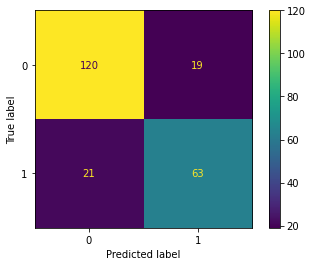

In [65]:
cm = confusion_matrix(y_test, y_pred, labels=model1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=model1.classes_)
disp.plot()

plt.show()

In [66]:
print(classification_report(y_test,y_pred))

# 86% of the true non-survivers were predicted correctly (recall of class 0)
# 85% of the 0 predictions were correct

# If i had predicted that all the passengers died, the accuracy would have been 0.62 (139/(139+84))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       139
           1       0.77      0.75      0.76        84

    accuracy                           0.82       223
   macro avg       0.81      0.81      0.81       223
weighted avg       0.82      0.82      0.82       223



Optimize model hyperparameters

In [67]:
param_grid = [{'max_depth': [8, 12, 16], 
         'min_samples_split': [12, 16, 20], 
         'criterion': ['gini', 'entropy']}]

print(param_grid)

[{'max_depth': [8, 12, 16], 'min_samples_split': [12, 16, 20], 'criterion': ['gini', 'entropy']}]


In [68]:
rf=RandomForestClassifier()
grid=GridSearchCV(estimator=rf,param_grid=param_grid,cv=10,n_jobs=-1,verbose=2)
grid.fit(X_train,y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV] END ..criterion=gini, max_depth=8, min_samples_split=16; total time=   0.4s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=12; total time=   0.4s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=12; total time=   0.4s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=12; total time=   0.4s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=12; total time=   0.4s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=12; total time=   0.5s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=16; total time=   0.5s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=12; total time=   0.5s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=16; total time=   0.5s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=16; total time=   0.5s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=12; total time=   0.5s
[CV] END ..criterion=gini, max_depth=8, min_sa

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [8, 12, 16],
                          'min_samples_split': [12, 16, 20]}],
             verbose=2)

In [69]:
grid.best_params_ 

{'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 16}

In [70]:
# to see the results
grid.best_estimator_

# save it into best_grid
model_cv=grid.best_estimator_

In [71]:
y_pred_cv = model_cv.predict(X_test)

print('Accuracy of random foresct selected by CV in test set:',np.mean(y_test==y_pred_cv))

Accuracy of random foresct selected by CV in test set: 0.8430493273542601


In [72]:
# Another way to calculate the accuracy (more direct)

print('Accuracy of random foresct selected by CV in test set:',grid.score(X_test, y_test))

Accuracy of random foresct selected by CV in test set: 0.8430493273542601


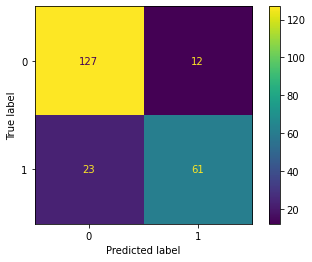

In [73]:
cm = confusion_matrix(y_test, y_pred_cv, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=grid.classes_)
disp.plot()

plt.show()

In [74]:
print(classification_report(y_test,y_pred_cv))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       139
           1       0.84      0.73      0.78        84

    accuracy                           0.84       223
   macro avg       0.84      0.82      0.83       223
weighted avg       0.84      0.84      0.84       223

